[[[ 58 614 639 491]]

 [[  0 135 555  18]]

 [[389  46 418 184]]

 [[202 288 244 487]]

 [[100 511 357 456]]

 [[425 231 470 440]]

 [[  1  64 300   0]]

 [[307 474 524 428]]

 [[158  98 184 223]]

 [[ 51 397  77 522]]

 [[  0 132 277  73]]

 [[  0 343  57 611]]

 [[193  88 244  77]]

 [[581   6 637 271]]

 [[611 279 636 400]]

 [[295  66 552  11]]

 [[579   0 639 282]]

 [[551  11 577 136]]

 [[459 442 495 435]]

 [[ 49 402  74 520]]

 [[361 458 477 430]]

 [[183 501 197 498]]

 [[ 78 523  90 521]]

 [[541 424 569 418]]

 [[166 118 186 218]]

 [[501 422 533 414]]

 [[387 431 400 495]]

 [[215 493 256 484]]

 [[171 591 228 579]]

 [[308 472 332 466]]

 [[577 398 609 389]]

 [[298  53 313 115]]

 [[209 495 293 477]]

 [[431 248 449 327]]

 [[256 184 264 222]]

 [[388  54 416 184]]

 [[197 279 240 480]]

 [[310  79 317 111]]

 [[585 405 611 399]]

 [[174 488 205 482]]

 [[441 294 472 432]]

 [[230 106 233 120]]

 [[243 108 245 123]]

 [[362 467 406 454]]

 [[520 422 568 411]]

 [[543  14

<function matplotlib.pyplot.show(close=None, block=None)>

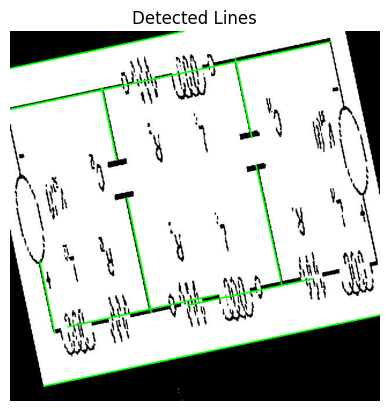

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("ref des raw.v1i.yolov8/test/images/251_png_jpg.rf.520671018e926b40663e7bc2666d2f40.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, threshold1=50, threshold2=100, apertureSize=3)
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=75, minLineLength=5, maxLineGap=10)
print(lines)
print(len(lines))
line_image = image.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis("off")
plt.show

90
[array([555,  18], dtype=int32), array([552,  11], dtype=int32), array([551,  11], dtype=int32), array([543,  14], dtype=int32)]
[array([357, 456], dtype=int32), array([361, 458], dtype=int32), array([362, 467], dtype=int32)]


<function matplotlib.pyplot.show(close=None, block=None)>

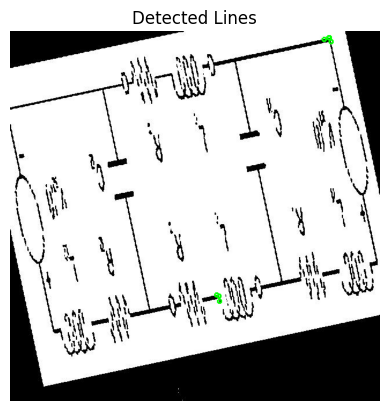

In [32]:
# lets cluster the points and check for intersection --> I will do this very simply at first as POC
# and then see if I can find a better algorithm that keeps a moving average cluster center. 
threshold = 10
clusters = []
for line in lines:
    x0, y0, x1, y1 = line[0]
    pt1, pt2 = np.array([x0, y0]), np.array([x1, y1])
    added1 = False
    added2 = False
    for cluster in clusters:

        if any(np.linalg.norm(pt1 - cpt) < threshold for cpt in cluster):
            cluster.append(pt1)
            added1 = True
            break

        if any(np.linalg.norm(pt2 - cpt) < threshold for cpt in cluster):
            cluster.append(pt2)
            added2 = True
            break

    if not added1:
        clusters.append([pt1])
    if not added2:
        clusters.append([pt2])

clust_image = image.copy()

print(len(clusters))
for clust in clusters:
    if len(clust) >= 3:
        print(clust)
        for pt in clust:
            x, y = pt
            cv2.circle(clust_image, (x, y), 3, (0, 255, 0), 2)


plt.imshow(cv2.cvtColor(clust_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis("off")
plt.show

    

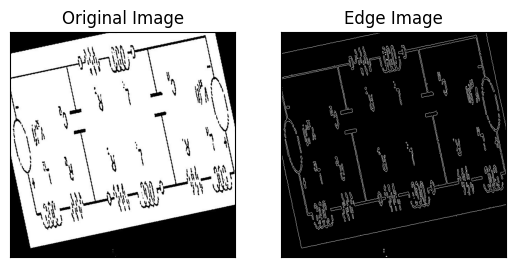

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

